In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from erode_image import erode_image
from dilate_image import dilate_image

In [2]:
def calculate_ndwi(image):

    # Split the image into B, G, R channels
    B, G, R = cv2.split(image)
    
    # Simulate NIR (Near Infrared) channel for the sake of this example
    # In real satellite images, NIR would be a separate band.
    # Here we just use the red channel as a placeholder for NIR.
    NIR = R
    
    # Calculate NDWI
    ndwi = (G.astype(float) - NIR.astype(float)) / (G + NIR)
    
    return ndwi

In [3]:
def detect_water(image, threshold=0.1):
    ndwi = calculate_ndwi(image)
    
    # Apply threshold to create a binary mask of water regions
    water_mask = np.where(ndwi > threshold, 1, 0).astype(np.uint8)
    
    return water_mask

# Wykrywanie wody

/var/folders/88/pqr7tn3n40x03r8kcxv8n9ym0000gn/T/ipykernel_2457/3348519364.py:12: RuntimeWarning: divide by zero encountered in divide
  ndwi = (G.astype(float) - NIR.astype(float)) / (G + NIR)
/var/folders/88/pqr7tn3n40x03r8kcxv8n9ym0000gn/T/ipykernel_2457/3348519364.py:12: RuntimeWarning: invalid value encountered in divide
  ndwi = (G.astype(float) - NIR.astype(float)) / (G + NIR)


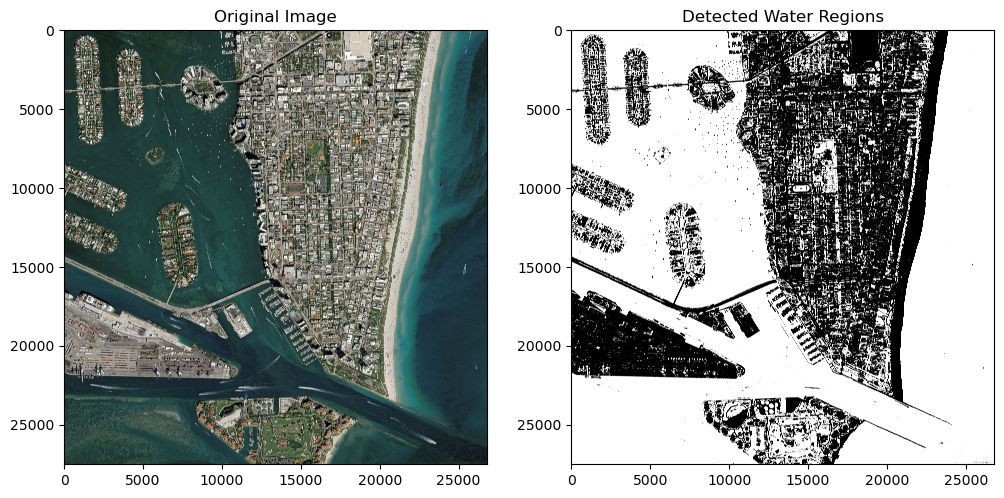

In [4]:
# Load the satellite image
image = cv2.imread('../satellite-images/Miami.jpg')


# Detect water in the image
water_mask = detect_water(image, threshold=0.03)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Detected Water Regions')
plt.imshow(water_mask, cmap='gray')

plt.show()


## Erozja 

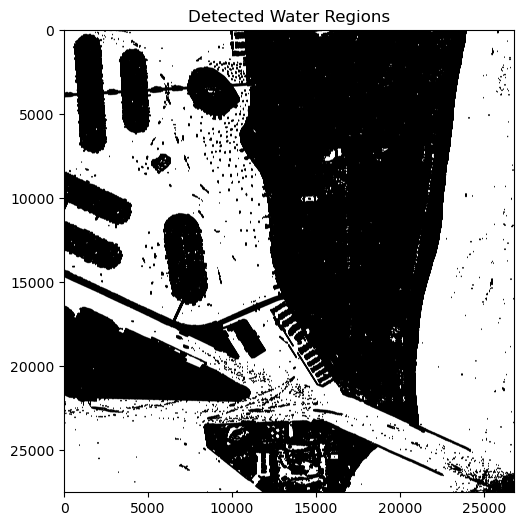

In [5]:
eroded_image=np.copy(water_mask)
eroded_image=erode_image(water_mask, kernel_size=10, iterations=8)

plt.figure(figsize=(12, 6))

plt.title('Detected Water Regions')
plt.imshow(eroded_image, cmap='gray')

## Filtr medianowy (on trwa trochę bo jest sporo iteracji)

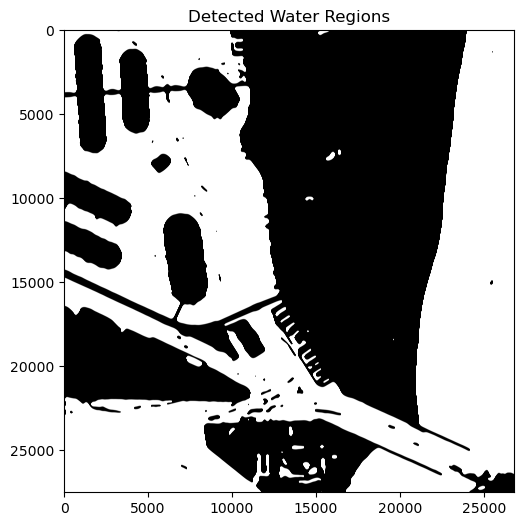

In [6]:
filtered_image=np.copy(eroded_image)

for i in range(10):
    filtered_image = cv2.medianBlur(filtered_image, ksize=105)  # ksize to rozmiar maski, powinien być liczbą nieparzystą


plt.figure(figsize=(12, 6))
plt.title('Detected Water Regions')
plt.imshow(filtered_image, cmap='gray')

## Dylatacja

['../dilated_image_water_mask.pkl']

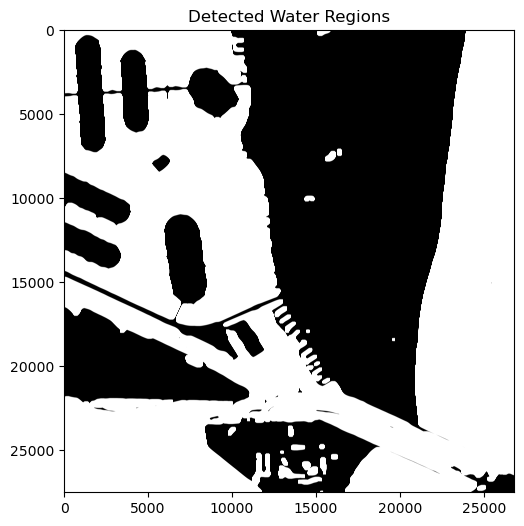

In [7]:
dilated_image=np.copy(filtered_image)
dilated_image=dilate_image(dilated_image, kernel_size=40, iterations=3)

plt.figure(figsize=(12, 6))

plt.title('Detected Water Regions')
plt.imshow(dilated_image, cmap='gray')

import joblib
joblib.dump(dilated_image, "../dilated_image_water_mask.pkl")

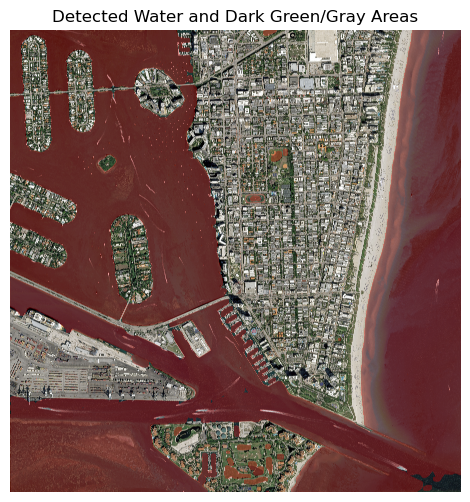

In [12]:
mask = np.copy(dilated_image)

# Stwórz czerwoną przezroczystą maskę
overlay = image.copy()
output = image.copy()
overlay[mask > 0] = (0, 0, 255)  # kolor czerwony w BGR

# Połącz obraz z maską z przezroczystością
alpha = 0.3  # przezroczystość
cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

# Konwertuj obraz z BGR na RGB dla poprawnego wyświetlania w Matplotlib
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
# Wyświetl obraz za pomocą Matplotlib
plt.imshow(output_rgb)
plt.title('Detected Water and Dark Green/Gray Areas')
plt.axis('off')
plt.show()



## Wykrywanie łodek

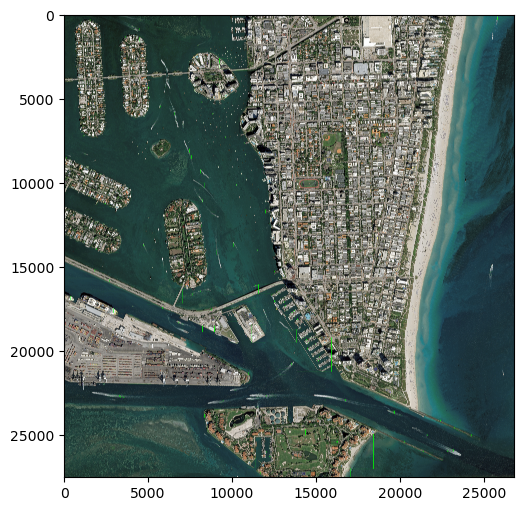

In [17]:
import cv2
import numpy as np

def detect_boats(satellite_image, water_mask, output_image_path):

  
    # Zastosuj maskę na obraz satelitarny
    masked_image = cv2.bitwise_and(satellite_image, satellite_image, mask=water_mask)

    # Konwersja do odcieni szarości
    gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    # Usunięcie szumu za pomocą rozmycia Gaussowskiego
    blurred = cv2.GaussianBlur(gray, (5, 5), 1)

    edges = cv2.Canny(blurred, 50, 150)

    
    # Wykrycie krawędzi przy użyciu algorytmu Canny'ego
    # edges = cv2.Canny(blurred, 50, 150)

    # Znalezienie konturów
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Próg dla minimalnego rozmiaru łódki (można dostosować)
    min_area = 1000

    # Przeglądanie konturów i rysowanie prostokątów wokół wykrytych łódek
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(satellite_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Zapisz wynikowy obraz
    cv2.imwrite(output_image_path, satellite_image)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(satellite_image, cv2.COLOR_BGR2RGB))

detect_boats(np.copy(image), np.copy(dilated_image), 'output_image_with_boats.jpg')
